In [65]:
from pathlib import Path
import torchio as tio
import numpy as np
import torch

labelmap_paths = sorted(Path('labelmaps').glob('*.nii.gz'))
subjects = []

for path in labelmap_paths:
    subject = tio.Subject(
        labelmap=tio.LabelMap(path)
    )
    subjects.append(subject)

dataset = tio.SubjectsDataset(subjects)


In [66]:
class GenerateSyntheticMRI(tio.Transform):
    def __init__(self, label_range=(1, 6), shared_mean=100.0, shared_std=10.0):
        super().__init__()
        self.label_range = label_range
        self.shared_mean = float(shared_mean)
        self.shared_std = float(shared_std)

    def apply_transform(self, subject):
        label_tensor = subject['labelmap'].data.clone()
        synthetic_tensor = torch.zeros_like(label_tensor).float()  # Force float32

        labels = torch.unique(label_tensor).tolist()
        for label in labels:
            if label == 0:
                continue
            mask = label_tensor == label

            # Create intensity values
            if self.label_range[0] <= label <= self.label_range[1]:
                values = torch.randn_like(mask.float()) * self.shared_std + self.shared_mean
            else:
                mean = float(np.random.uniform(50, 150))
                std = float(np.random.uniform(5, 20))
                values = torch.randn_like(mask.float()) * std + mean

            values = values.float()  # Explicitly cast to float32
            synthetic_tensor[mask] = values[mask]

        subject['image'] = tio.ScalarImage(tensor=synthetic_tensor, affine=subject['labelmap'].affine)
        return subject


In [67]:
class RandomResample(tio.Transform):
    def __init__(self, min_spacing=(.2, .2, .2), max_spacing=(1.0, 1.0, 1.0), p=1.0):
        super().__init__(p=p)
        self.min_spacing = np.array(min_spacing)
        self.max_spacing = np.array(max_spacing)

    def apply_transform(self, subject):
        random_spacing = np.random.uniform(self.min_spacing, self.max_spacing)
        resample = tio.Resample(random_spacing, image_interpolation='linear', exclude=['labelmap'])
        return resample(subject)


In [68]:
transform = tio.Compose([
    # 1. Anatomical deformations applied to labelmap (and carried over to synthetic image)
    tio.RandomAffine(scales=(0.95, 1.05), degrees=10, translation=5, p=0.75),
    tio.RandomElasticDeformation(num_control_points=7, max_displacement=7.5, p=0.5),

    # 2. Generate synthetic image from deformed labelmap
    GenerateSyntheticMRI(),

    # 3. Simulate acquisition: spatial resolution loss only to image
    RandomResample( min_spacing=(.2, .2, .2), max_spacing=(1.5, 1.5, 1.5), p=1.0),

    # 4. MRI acquisition-like artifacts (image only)
    tio.RandomMotion(p=0.3, exclude=['labelmap']),
    tio.RandomGhosting(p=0.2, exclude=['labelmap']),
    tio.RandomSpike(p=0.2, exclude=['labelmap']),
    tio.RandomBiasField(p=0.3, exclude=['labelmap']),
    tio.RandomNoise(p=0.2, mean=0.0, std=(0, 0.05), exclude=['labelmap']),
    tio.RandomBlur(p=0.2, std=(0.25, 1.0), exclude=['labelmap']),
    tio.RandomGamma(log_gamma=(-0.3, 0.3), p=0.2, exclude=['labelmap']),
    tio.RandomAnisotropy(p=0.2, downsampling=(1, 4), exclude=['labelmap']),
])


In [69]:
augmented_dataset = tio.SubjectsDataset(subjects, transform=transform)
loader = torch.utils.data.DataLoader(augmented_dataset, batch_size=1, shuffle=True)


In [70]:
from pathlib import Path

def save_samples(dataset, output_dir='output_samples', n=10):
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for i, subject in enumerate(dataset):
        if i >= n:
            break
        subject['image'].save(output_dir / f'image_{i:03}.nii.gz')
        subject['labelmap'].save(output_dir / f'label_{i:03}.nii.gz')


In [71]:
# save_samples(augmented_dataset, n=10)


In [72]:
import matplotlib.pyplot as plt

def visualize_sample(subject, figsize=(15, 10), cmap='gray', alpha=0.4):
    # Resample image to labelmap resolution for visualization
    upsampled_image = tio.Resample(
        target=subject['labelmap'],
        image_interpolation='linear'  # preserve float intensity
    )(subject)['image']

    image = upsampled_image.data.squeeze().numpy()
    labelmap = subject['labelmap'].data.squeeze().numpy()

    # Compute center slices
    z, y, x = np.array(image.shape) // 2

    def overlay_slice(img_slice, lbl_slice, title, axis):
        axis.imshow(img_slice, cmap=cmap)
        axis.imshow(lbl_slice, cmap='jet', alpha=alpha)
        axis.set_title(title)
        axis.axis('off')

    fig, axs = plt.subplots(2, 3, figsize=figsize)

    # No overlay (top row)
    axs[0, 0].imshow(image[z, :, :], cmap=cmap)
    axs[0, 0].set_title('Sagittal (no overlay)')
    axs[0, 1].imshow(image[:, y, :], cmap=cmap)
    axs[0, 1].set_title('Coronal (no overlay)')
    axs[0, 2].imshow(image[:, :, x], cmap=cmap)
    axs[0, 2].set_title('Axial (no overlay)')

    for ax in axs[0]:
        ax.set_xticks([])
        ax.set_yticks([])
        
    # With overlay (bottom row)
    overlay_slice(image[z, :, :], labelmap[z, :, :], 'Axial (overlay)', axs[1, 0])
    overlay_slice(image[:, y, :], labelmap[:, y, :], 'Coronal (overlay)', axs[1, 1])
    overlay_slice(image[:, :, x], labelmap[:, :, x], 'Sagittal (overlay)', axs[1, 2])

    plt.tight_layout()
    plt.show()


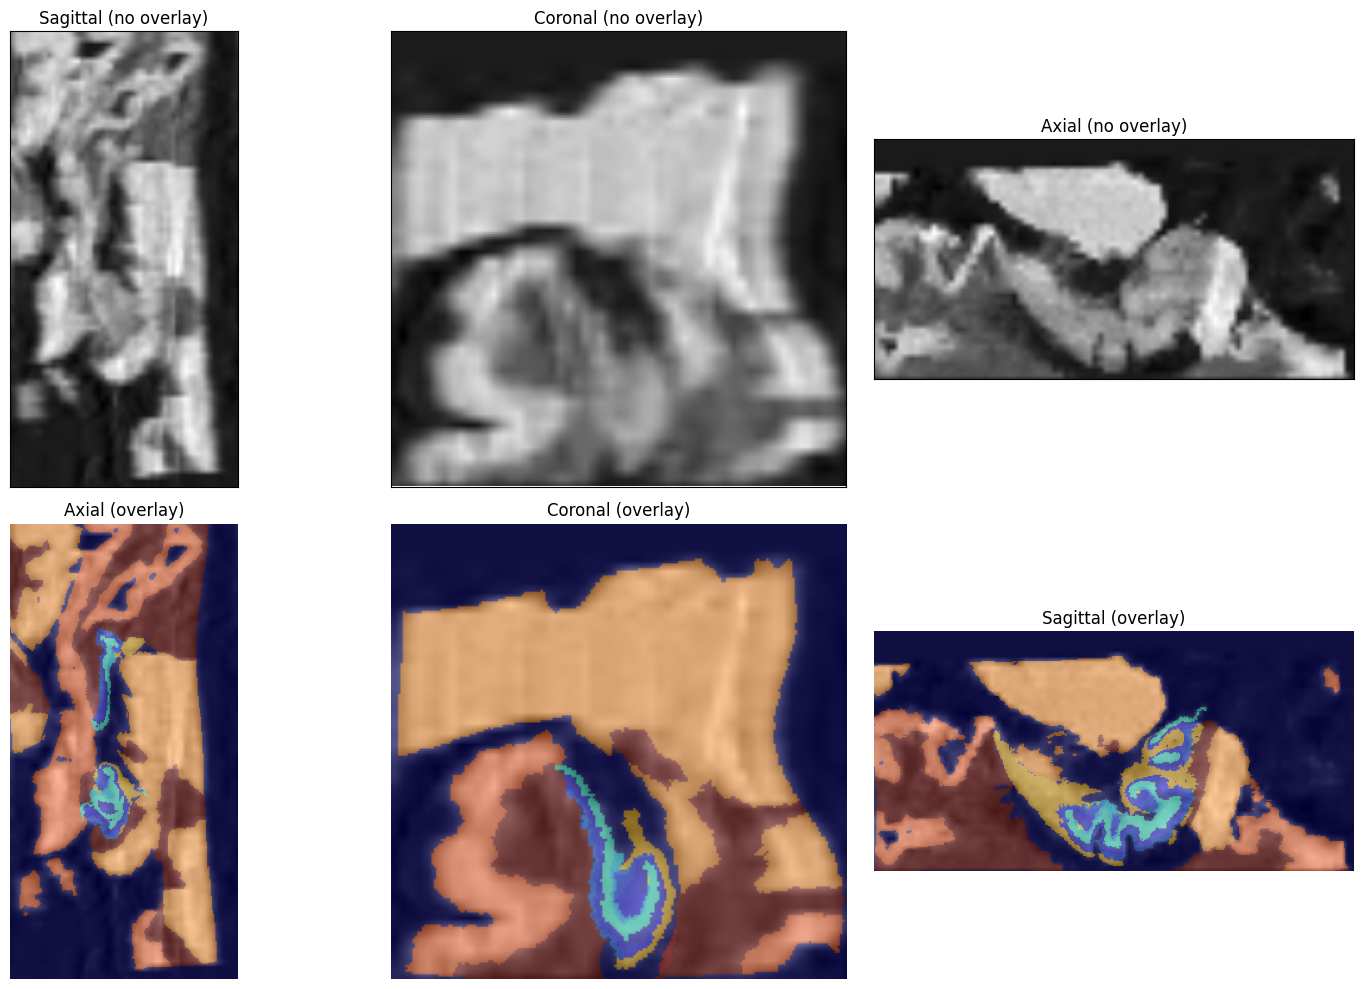

In [88]:
subject = augmented_dataset[0]  # or any other index
visualize_sample(subject)